In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['create-extracted-json-fields-dataset', 'ga-customer-revenue-prediction']


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig
    
def softmax(X, theta = 1.0, axis = None):
    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter, 
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

In [3]:
#Reference https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
import json
from pandas.io.json import json_normalize
def load_df(csv_path='../input/ga-customer-revenue-prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [4]:
%%time
train_df = load_df()
test_df = load_df("../input/ga-customer-revenue-prediction/test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 5min 2s, sys: 12 s, total: 5min 14s
Wall time: 5min 14s


In [5]:
import datetime
for df in (train_df, test_df):
    df['date'] = df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [6]:
print(min(test_df["date"]), max(test_df["date"]))
print(min(train_df["date"]), max(train_df["date"]))

2017-08-02 2018-04-30
2016-08-01 2017-08-01


In [7]:
%%time
train_df.to_feather('train_not_clean.feather')
test_df.to_feather('test_not_clean.feather')

CPU times: user 12.6 s, sys: 3.73 s, total: 16.3 s
Wall time: 19 s


In [8]:
#train_df= pd.read_feather('train_not_clean.feather')
#test_df = pd.read_feather('test_not_clean.feather')
display(train_df.head())
display(test_df.head())

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,Fal

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2017-10-16,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,Asia,Singapore,not available in demo dataset,not available in demo dataset,(not set),myrepublic.com.sg,not available in demo dataset,(not set),Southeast Asia,NaN,4,NaN,4,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,Organic Search,2017-10-16,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Zaragoza,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),rima-tde.net,not available in demo dataset,Aragon,Southern Europe,NaN,5,1,5,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,2017-10-16,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,France,not available in demo dataset,not available in demo dataset,not available in demo dataset,sfr.net,not available in demo dataset,not available in demo dataset,Western Europe,NaN,7,1,7,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,2017-10-16,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not avail

In [9]:
# https://www.kaggle.com/prashantkikani/teach-lightgbm-to-sum-predictions-fe
def browser_mapping(x):
    browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
    if x in browsers:
        return x.lower()
    elif  ('android' in x) or ('samsung' in x) or ('mini' in x) or ('iphone' in x) or ('in-app' in x) or ('playstation' in x):
        return 'mobile browser'
    elif  ('mozilla' in x) or ('chrome' in x) or ('blackberry' in x) or ('nokia' in x) or ('browser' in x) or ('amazon' in x):
        return 'mobile browser'
    elif  ('lunascape' in x) or ('netscape' in x) or ('blackberry' in x) or ('konqueror' in x) or ('puffin' in x) or ('amazon' in x):
        return 'mobile browser'
    elif '(not set)' in x:
        return x
    else:
        return 'others'
    
    
def adcontents_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return 'ad'
    else:
        return 'others'
    
def source_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('youtube' in x):
        return 'youtube'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'bing' in x:
        return 'bing'
    elif 'quora' in x:
        return 'quora'
    elif 'outlook' in x:
        return 'outlook'
    elif 'linkedin' in x:
        return 'linkedin'
    elif 'pinterest' in x:
        return 'pinterest'
    elif 'ask' in x:
        return 'ask'
    elif 'siliconvalley' in x:
        return 'siliconvalley'
    elif 'lunametrics' in x:
        return 'lunametrics'
    elif 'amazon' in x:
        return 'amazon'
    elif 'mysearch' in x:
        return 'mysearch'
    elif 'qiita' in x:
        return 'qiita'
    elif 'messenger' in x:
        return 'messenger'
    elif 'twitter' in x:
        return 'twitter'
    elif 't.co' in x:
        return 't.co'
    elif 'vk.com' in x:
        return 'vk.com'
    elif 'search' in x:
        return 'search'
    elif 'edu' in x:
        return 'edu'
    elif 'mail' in x:
        return 'mail'
    elif 'ad' in x:
        return 'ad'
    elif 'golang' in x:
        return 'golang'
    elif 'direct' in x:
        return 'direct'
    elif 'dealspotr' in x:
        return 'dealspotr'
    elif 'sashihara' in x:
        return 'sashihara'
    elif 'phandroid' in x:
        return 'phandroid'
    elif 'baidu' in x:
        return 'baidu'
    elif 'mdn' in x:
        return 'mdn'
    elif 'duckduckgo' in x:
        return 'duckduckgo'
    elif 'seroundtable' in x:
        return 'seroundtable'
    elif 'metrics' in x:
        return 'metrics'
    elif 'sogou' in x:
        return 'sogou'
    elif 'businessinsider' in x:
        return 'businessinsider'
    elif 'github' in x:
        return 'github'
    elif 'gophergala' in x:
        return 'gophergala'
    elif 'yandex' in x:
        return 'yandex'
    elif 'msn' in x:
        return 'msn'
    elif 'dfa' in x:
        return 'dfa'
    elif '(not set)' in x:
        return '(not set)'
    elif 'feedly' in x:
        return 'feedly'
    elif 'arstechnica' in x:
        return 'arstechnica'
    elif 'squishable' in x:
        return 'squishable'
    elif 'flipboard' in x:
        return 'flipboard'
    elif 't-online.de' in x:
        return 't-online.de'
    elif 'sm.cn' in x:
        return 'sm.cn'
    elif 'wow' in x:
        return 'wow'
    elif 'baidu' in x:
        return 'baidu'
    elif 'partners' in x:
        return 'partners'
    else:
        return 'others'

train_df['device.browser'] = train_df['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
train_df['trafficSource.adContent'] = train_df['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
train_df['trafficSource.source'] = train_df['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

test_df['device.browser'] = test_df['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
test_df['trafficSource.adContent'] = test_df['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
test_df['trafficSource.source'] = test_df['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')


In [10]:
len(train_df.columns)

55

In [11]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total NaN Values', 'Percentage of NaN Values'])

missing = missing_data(train_df).head(15)

In [12]:
missing

,Total NaN Values,Percentage of NaN Values
trafficSource.campaignCode,903652,99.999889
totals.transactionRevenue,892138,98.725728
trafficSource.adwordsClickInfo.slot,882193,97.625195
trafficSource.adwordsClickInfo.page,882193,97.625195
trafficSource.adwordsClickInfo.isVideoAd,882193,97.625195
trafficSource.adwordsClickInfo.adNetworkType,882193,97.625195
trafficSource.adwordsClickInfo.gclId,882092,97.614018
trafficSource.isTrueDirect,629648,69.678073
trafficSource.referralPath,572712,63.377425
trafficSource.keyword,502929,55.655102


In [13]:
display(train_df["trafficSource.isTrueDirect"].value_counts())

True    274005
Name: trafficSource.isTrueDirect, dtype: int64

In [14]:
display(train_df["totals.newVisits"].value_counts()/train_df.shape[0])

1    0.77802
Name: totals.newVisits, dtype: float64

In [15]:
train_df["totals.bounces"].value_counts()/train_df.shape[0]

1    0.498676
Name: totals.bounces, dtype: float64

In [16]:
train_df["trafficSource.referralPath"].value_counts()

/                                                                                                                                                                                  75523
/yt/about/                                                                                                                                                                         71036
/analytics/web/                                                                                                                                                                    14620
/yt/about/tr/                                                                                                                                                                      14599
/yt/about/vi/                                                                                                                                                                      13753
/yt/about/es-419/                                                          

In [17]:
train_df["trafficSource.keyword"].value_counts().head()

(not provided)                     366363
6qEhsCssdK0z36ri                    11503
(Remarketing/Content targeting)      2298
1hZbAqLCbjwfgOH7                     2264
google merchandise store             2209
Name: trafficSource.keyword, dtype: int64

In [18]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [19]:
train_df = train_df.drop(['trafficSource.campaignCode', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.page', 
                          'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.isVideoAd',
                          'trafficSource.adwordsClickInfo.gclId', 'trafficSource.isTrueDirect', 'trafficSource.referralPath', 'trafficSource.keyword', 
                          'totals.bounces', 'totals.newVisits'], axis = 1)
display(train_df.shape)

(903653, 43)

In [20]:
test_df = test_df.drop(['trafficSource.adContent', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.adNetworkType', 
                        'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.gclId', 
                        'trafficSource.isTrueDirect', 'trafficSource.referralPath', 'trafficSource.keyword', 
                        'totals.bounces', 'totals.newVisits'], axis = 1)
display(test_df.shape)

(804684, 42)

In [21]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0)

In [22]:
display(train_df.shape)
train_df = train_df.dropna()
display(train_df.shape)

(903653, 43)

(903553, 43)

In [23]:
useless_columns = ["socialEngagementType", "device.browserSize", "device.browserVersion", "device.flashVersion", "device.language",
                         "device.mobileDeviceBranding", "device.mobileDeviceInfo", "device.mobileDeviceMarketingName", "device.mobileDeviceModel",
                         "device.mobileInputSelector", "device.operatingSystemVersion", "device.screenColors", "device.screenResolution", 
                         "geoNetwork.cityId", "geoNetwork.latitude", "geoNetwork.longitude","geoNetwork.networkLocation", 
                          "trafficSource.adwordsClickInfo.criteriaParameters", "totals.visits"]

In [ ]:
for column in useless_columns:
    print(train_df[column].value_counts())

Not Socially Engaged    903553
Name: socialEngagementType, dtype: int64
not available in demo dataset    903553
Name: device.browserSize, dtype: int64
not available in demo dataset    903553
Name: device.browserVersion, dtype: int64
not available in demo dataset    903553
Name: device.flashVersion, dtype: int64
not available in demo dataset    903553
Name: device.language, dtype: int64
not available in demo dataset    903553
Name: device.mobileDeviceBranding, dtype: int64
not available in demo dataset    903553
Name: device.mobileDeviceInfo, dtype: int64
not available in demo dataset    903553
Name: device.mobileDeviceMarketingName, dtype: int64
not available in demo dataset    903553
Name: device.mobileDeviceModel, dtype: int64
not available in demo dataset    903553
Name: device.mobileInputSelector, dtype: int64
not available in demo dataset    903553
Name: device.operatingSystemVersion, dtype: int64
not available in demo dataset    903553
Name: device.screenColors, dtype: int64
not 

In [ ]:
train_df = train_df.drop(useless_columns, axis = 1)
display(train_df.shape)

(903553, 24)

In [ ]:
test_df = test_df.drop(useless_columns, axis = 1)
display(test_df.shape)

(804684, 23)

In [ ]:
def process_device(data_df):
    print("Done")
    data_df['source.country'] = data_df['trafficSource.source'] + '_' + data_df['geoNetwork.country']
    data_df['campaign.medium'] = data_df['trafficSource.campaign'] + '_' + data_df['trafficSource.medium']
    data_df['browser.category'] = data_df['device.browser'] + '_' + data_df['device.deviceCategory']
    data_df['browser.os'] = data_df['device.browser'] + '_' + data_df['device.operatingSystem']
    return data_df

train_df = process_device(train_df)
test_df = process_device(test_df)

def custom(data):
    print('Done')
    data['device_deviceCategory_channelGrouping'] = data['device.deviceCategory'] + "_" + data['channelGrouping']
    data['channelGrouping_browser'] = data['device.browser'] + "_" + data['channelGrouping']
    data['channelGrouping_OS'] = data['device.operatingSystem'] + "_" + data['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            data[i + "_" + j] = data[i] + "_" + data[j]
    
    #data['content.source'] = data['trafficSource.adContent'] + "_" + data['source.country']
    data['medium.source'] = data['trafficSource.medium'] + "_" + data['source.country']
    return data

train_df = custom(train_df)
test_df = custom(test_df)

Done
Done
Done
Done


In [ ]:
train_df.dtypes

channelGrouping                                    object
date                                               object
fullVisitorId                                      object
sessionId                                          object
visitId                                             int64
visitNumber                                         int64
visitStartTime                                      int64
device.browser                                     object
device.deviceCategory                              object
device.isMobile                                      bool
device.operatingSystem                             object
geoNetwork.city                                    object
geoNetwork.continent                               object
geoNetwork.country                                 object
geoNetwork.metro                                   object
geoNetwork.networkDomain                           object
geoNetwork.region                                  object
geoNetwork.sub

In [24]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime'
]

categorical_features = [
    _f for _f in train_df.columns
    if (_f not in excluded_features) & (train_df[_f].dtype == 'object')
]

In [25]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype("float64")

In [26]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

#train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



Description of SubContinent count: 
United States     364697
India              51137
United Kingdom     37389
Canada             25867
Vietnam            24596
Turkey             20522
Thailand           20123
Germany            19979
Name: geoNetwork.country, dtype: int64


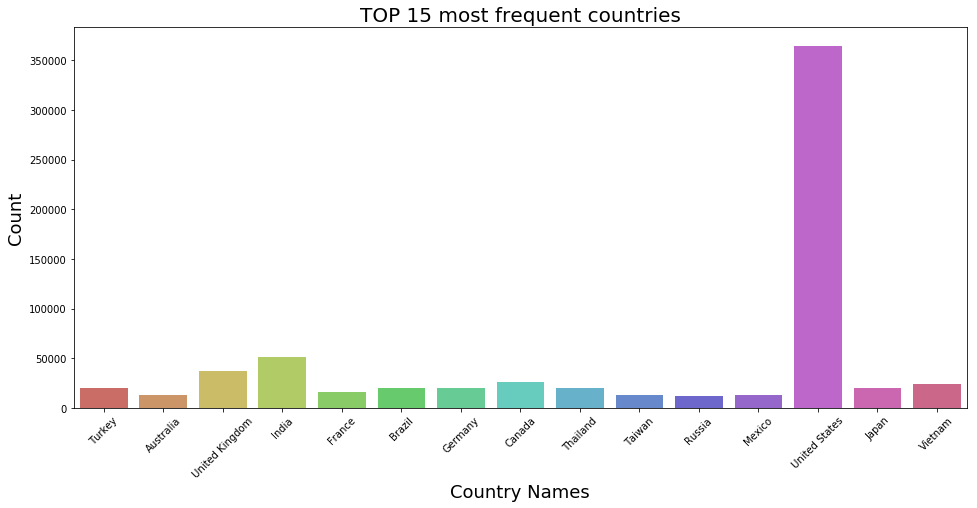

In [27]:
# the top 8 of browsers represent % of total
print("Description of SubContinent count: ")
print(train_df['geoNetwork.country'].value_counts()[:8]) # printing the top 7 percentage of browsers

# seting the graph size
plt.figure(figsize=(16,7))

# let explore the browser used by users
sns.countplot(train_df[train_df['geoNetwork.country']\
                       .isin(train_df['geoNetwork.country']\
                             .value_counts()[:15].index.values)]['geoNetwork.country'], palette="hls") # It's a module to count the category's
plt.title("TOP 15 most frequent countries", fontsize=20) # seting the title size
plt.xlabel("Country Names", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

plt.show() #use plt.show to render the graph that we did above

Description of SubContinent count: 
Northern America    390608
Southeast Asia       77794
Southern Asia        59317
Western Europe       59109
Northern Europe      58164
Eastern Asia         46912
Eastern Europe       45242
South America        41723
Name: geoNetwork.subContinent, dtype: int64


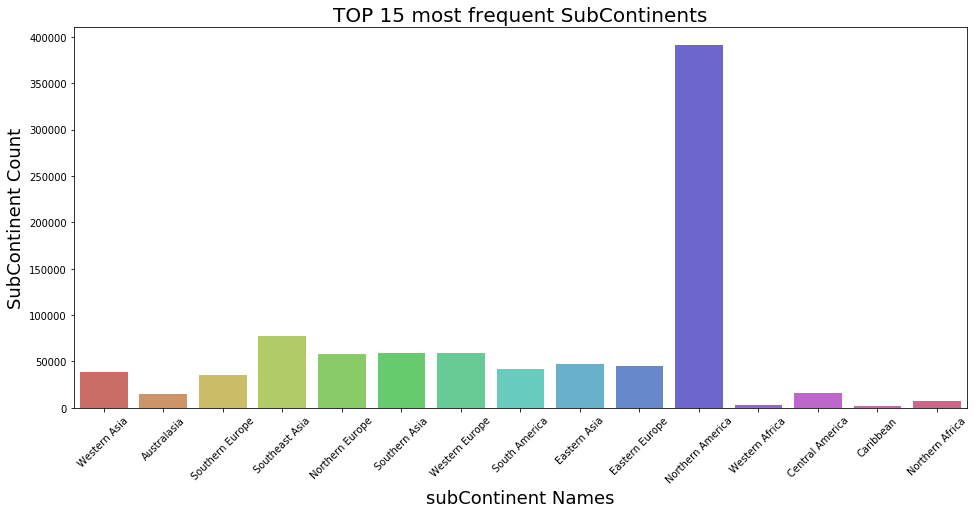

In [28]:
# the top 8 of browsers represent % of total
print("Description of SubContinent count: ")
print(train_df['geoNetwork.subContinent'].value_counts()[:8]) # printing the top 7 percentage of browsers

# seting the graph size
plt.figure(figsize=(16,7))

# let explore the browser used by users
sns.countplot(train_df[train_df['geoNetwork.subContinent']\
                       .isin(train_df['geoNetwork.subContinent']\
                             .value_counts()[:15].index.values)]['geoNetwork.subContinent'], palette="hls") # It's a module to count the category's
plt.title("TOP 15 most frequent SubContinents", fontsize=20) # seting the title size
plt.xlabel("subContinent Names", fontsize=18) # seting the x label size
plt.ylabel("SubContinent Count", fontsize=18) # seting the y label size
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

plt.show() #use plt.show to render the graph that we did above

In [29]:
def PieChart(df_colum, title, limit=15):
    """
    This function helps to investigate the proportion of visits and total of transction revenue 
    by each category
    """

    count_trace = train_df[df_colum].value_counts()[:limit].to_frame().reset_index()
    #count_trace.iloc[2] = count_trace.iloc[1]
    #count_trace = count_trace.iloc[2:]
    rev_trace = train_df.groupby(df_colum)["totals.transactionRevenue"].sum().nlargest(10).to_frame().reset_index()

    trace1 = go.Pie(labels=count_trace['index'], values=count_trace[df_colum], name= "% Acesses", hole= .5, 
                    hoverinfo="label+percent+name", showlegend=True,domain= {'x': [0, .48]}, 
                    marker=dict(colors=color))

    trace2 = go.Pie(labels=rev_trace[df_colum], 
                    values=rev_trace['totals.transactionRevenue'], name="% Revenue", hole= .5, 
                    hoverinfo="label+percent+name", showlegend=False, domain= {'x': [.52, 1]})

    layout = dict(title= title, height=450, font=dict(size=15),
                  annotations = [
                      dict(
                          x=.25, y=.5,
                          text='Visits', 
                          showarrow=False,
                          font=dict(size=20)
                      ),
                      dict(
                          x=.80, y=.5,
                          text='Revenue', 
                          showarrow=False,
                          font=dict(size=20)
                      )
        ])

    fig = dict(data=[trace1, trace2], layout=layout)
    py.iplot(fig)

In [30]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.campaign,trafficSource.medium,trafficSource.source
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,0.0,1,not available in demo dataset,(not set),organic,google
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,0.0,1,not available in demo dataset,(not set),organic,google
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,0.0,1,not available in demo dataset,(not set),organic,google
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,mobile browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dat

In [31]:
PieChart("device.operatingSystem", "Top Operating Systems by Visits and Revenue", limit=12)

In [32]:
PieChart("geoNetwork.city", "Top Cities by Visits and Revenue", limit=12)

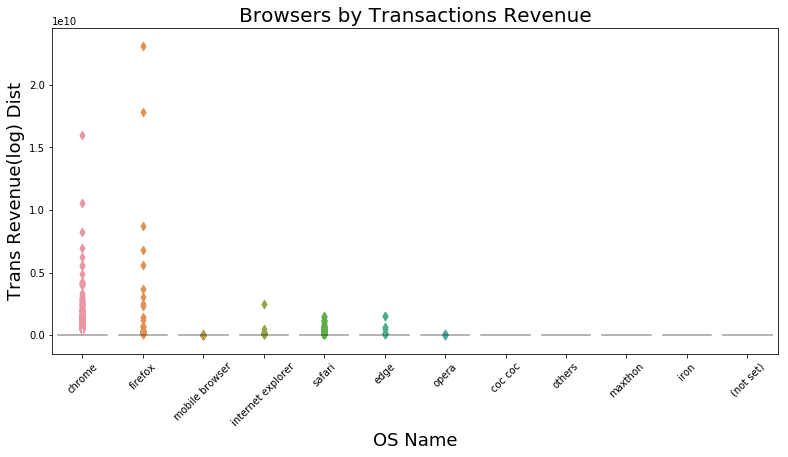

In [33]:
plt.figure(figsize=(13,6)) #figure size

#It's another way to plot our data. using a variable that contains the plot parameters
g1 = sns.boxenplot(x='device.browser', y='totals.transactionRevenue', 
                   data=train_df[train_df['device.operatingSystem'].isin(train_df['device.operatingSystem'].value_counts()[:10].index.values)])
g1.set_title('Browsers by Transactions Revenue', fontsize=20) # title and fontsize
g1.set_xticklabels(g1.get_xticklabels(),rotation=45) # It's the way to rotate the xticks when we use variable to our graphs
g1.set_xlabel('OS Name', fontsize=18) # Xlabel
g1.set_ylabel('Trans Revenue(log) Dist', fontsize=18) #Ylabel

plt.show()

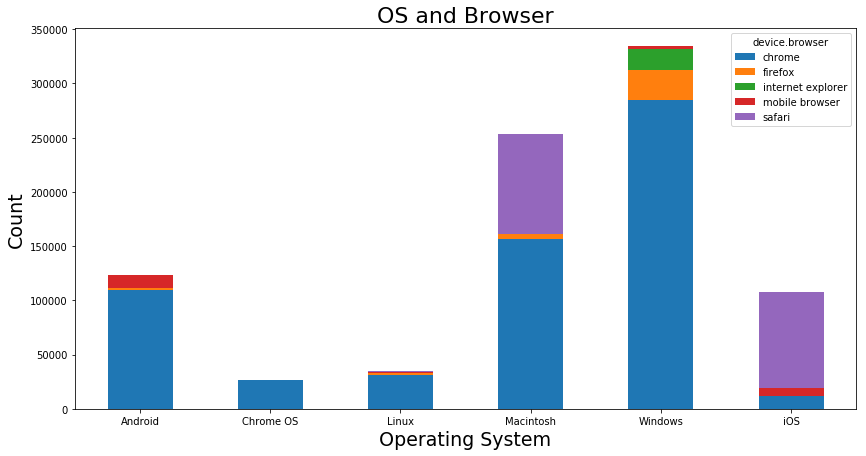

In [34]:
crosstab_eda = pd.crosstab(index=train_df[train_df['device.operatingSystem']\
                                          .isin(train_df['device.operatingSystem']\
                                                .value_counts()[:6].index.values)]['device.operatingSystem'], 
                           
                           # at this line, I am using the isin to select just the top 5 of browsers
                           columns=train_df[train_df['device.browser'].isin(train_df['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])
# Ploting the crosstab that we did above
crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                 figsize=(14,7), # adjusting the size of graphs
                 stacked=True)   # code to unstack 
plt.title("OS and Browser", fontsize=22) # adjusting title and fontsize
plt.xlabel("Operating System", fontsize=19) # adjusting x label and fontsize
plt.ylabel("Count", fontsize=19) # adjusting y label and fontsize
plt.xticks(rotation=0) # Adjust the xticks, rotating the labels

plt.show() # rendering

In [35]:
# Counting total visits by countrys
countMaps = pd.DataFrame(train_df['geoNetwork.country'].value_counts().sort_values(ascending = False)).reset_index()
countMaps.iloc[:,1] = np.log10(countMaps.iloc[:,1])
countMaps.columns=['country', 'counts'] #renaming columns
countMaps = countMaps.reset_index().drop('index', axis=1) #reseting index and droping the column

data = [ dict(
        type = 'choropleth',
        locations = countMaps['country'],
        locationmode = 'country names',
        z = countMaps['counts'],
        text = countMaps['country'],
        autocolorscale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of Visits'),
      ) ]

layout = dict(
    title = 'Log of Visits Per Country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

figure = dict( data=data, layout=layout )
py.iplot(figure, validate=False, filename='map-countrys-count')


In [36]:
sumRevMaps = train_df.groupby("geoNetwork.country")["totals.transactionRevenue"].sum().nlargest(1000).to_frame().reset_index()
#sumRevMaps = train_df.groupby("geoNetwork.country").sum().to_frame().reset_index()[4:]
sumRevMaps.iloc[:,1] = np.log2(sumRevMaps.iloc[:,1])
sumRevMaps.columns = ["country", "total_log"] # renaming columns
sumRevMaps = sumRevMaps.reset_index().drop('index', axis=1) #reseting index and drop index column

data = [ dict(
        type = 'choropleth',
        locations = sumRevMaps['country'],
        locationmode = 'country names',
        z = sumRevMaps['total_log'],
        text = sumRevMaps['country'],
        autocolorscale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Sum of Revenues'),
      ) ]

layout = dict(
    title = 'Log of Total Revenue by Country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

figure = dict( data=data, layout=layout )

py.iplot(figure, validate=False, filename='map-countrys-total')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log2



In [ ]:
for f in categorical_features:
    train_df[f], indexer = pd.factorize(train_df[f])
    test_df[f] = indexer.get_indexer(test_df[f])

In [ ]:
train_df.dtypes

In [ ]:
columns_to_train = []
for i in train_df.columns:
    if i not in ["date", "fullVisitorId", "sessionId", "visitId", "totals.transactionRevenue"]:
        columns_to_train.append(i)
print (columns_to_train)
train_df.loc[train_df['totals.transactionRevenue']>0, 'buyornobuy'] = 1
train_df.loc[train_df['totals.transactionRevenue']<=0, 'buyornobuy'] = 0

In [ ]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
FOLDs = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
clf = lgb.LGBMClassifier(class_weight='balanced', objective= 'binary',max_depth=8, colsample_bytree=0.8,learning_rate=0.01, min_child_samples=20, reg_alpha=1, reg_lambda=1, 
                    num_leaves=257, subsample=0.8)

In [ ]:
X = train_df.loc[:, columns_to_train]
Y = train_df["buyornobuy"]

oof_lgb = np.zeros(len(train_df))
predictions_lgb = np.zeros(len(test_df))

features_lgb = list(X.columns)
feature_importance_df_lgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(X, Y)):
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=Y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label=Y.iloc[val_idx])

    print("LGB " + str(fold_) + "-" * 50)
    num_round = 20000
    clf.fit(trn_data.data, trn_data.label, eval_set = [(val_data.data, val_data.label)], verbose = True, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration_)
    fold_importance_df_lgb = pd.DataFrame()
    fold_importance_df_lgb["feature"] = features_lgb
    fold_importance_df_lgb["importance"] = clf.feature_importances_
    fold_importance_df_lgb["fold"] = fold_ + 1
    feature_importance_df_lgb = pd.concat([feature_importance_df_lgb, fold_importance_df_lgb], axis=0)
    #clf_model.booster_ = clf
    #predictions_lgb += clf.predict_proba(X, num_iteration=clf.best_iteration_) / FOLDs.n_splits
    

In [ ]:
ypred = clf.predict(X, num_iteration=clf.best_iteration_)

In [ ]:
from sklearn.feature_selection import f_regression
X = train_df.loc[:, columns_to_train]
F, pval = f_regression(X=X, y=train_df['totals.transactionRevenue'])

In [ ]:
pval

In [ ]:
pval_df = pd.DataFrame(pval, index=X.columns)

In [ ]:
pval_df.iloc[:,0].sort_values(ascending=False).plot.bar(figsize = (12,12))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print(accuracy_score(train_df["buyornobuy"], ypred))
conf_mat = confusion_matrix(train_df["buyornobuy"], ypred)
print_confusion_matrix(conf_mat, ['No Buyer','Buyer'], (5,5), 20)

In [ ]:
yproba = clf.predict_proba(X, clf.best_iteration_)

In [ ]:
yproba = softmax(yproba, axis = 1)

In [ ]:
buyprob = yproba[:,1]

In [ ]:
toptenbuyers = []
for i in range(10):
    top = buyprob.argmax()
    toptenbuyers.append(top)
    buyprob[top] = 0

In [ ]:
for i in toptenbuyers:
    print(train_df.loc[i, 'fullVisitorId'])

In [ ]:
corr_matrix = train_df.corr()
(corr_matrix["totals.transactionRevenue"]).sort_values(ascending = False)

In [ ]:
top_ten = (corr_matrix["totals.transactionRevenue"]).sort_values(ascending = False).head(8)
last_ten = corr_matrix["totals.transactionRevenue"].sort_values(ascending = False).tail(8)

In [ ]:
total = pd.concat([top_ten, last_ten], axis = 0)

In [ ]:
corr_matrix = train_df[total.index].corr()

In [ ]:
trace = go.Heatmap(z=corr_matrix[total.index].values,
                   x=corr_matrix.columns,
                   y=corr_matrix.columns, colorscale='Viridis')
data=[trace]
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=go.Margin(
        l=300,
        r=50,
        b=300,
        t=100,
        pad=4
    ),
    #paper_bgcolor='#7f7f7f',
    #plot_bgcolor='#c7c7c7'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='size-margins')
#py.iplot(data, filename='labelled-heatmap')

In [ ]:
#Loading external data
train_store_1 = pd.read_csv('../input/exported-google-analytics-data/Train_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
train_store_2 = pd.read_csv('../input/exported-google-analytics-data/Train_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_1 = pd.read_csv('../input/exported-google-analytics-data/Test_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_2 = pd.read_csv('../input/exported-google-analytics-data/Test_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})

#Getting VisitId to Join with our train, test data
def get_visitid(id):
    bef_, af_ = str(x).split('.')
    return int(bef_), (int(af_)*10 if len(af_)==1 else int(af_))

for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    df["visitId"] = df["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(str)

train_exdata = pd.concat([train_store_1, train_store_2], sort=False)
test_exdata = pd.concat([test_store_1, test_store_2], sort=False)

for df in [train, test]:
    df["visitId"] = df["visitId"].astype(str)

# Merge with train/test data
train_new = train.merge(train_exdata, how="left", on="visitId")
test_new = test.merge(test_exdata, how="left", on="visitId")

# Drop Client Id
for df in [train_new, test_new]:
    df.drop("Client Id", 1, inplace=True)

#Cleaning Revenue
for df in [train_new, test_new]:
    df["Revenue"].fillna('$', inplace=True)
    df["Revenue"] = df["Revenue"].apply(lambda x: x.replace('$', '').replace(',', ''))
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
    df["Revenue"].fillna(0.0, inplace=True)

#Imputing NaN
for df in [train_new, test_new]:
    df["Sessions"] = df["Sessions"].fillna(0)
    df["Avg. Session Duration"] = df["Avg. Session Duration"].fillna(0)
    df["Bounce Rate"] = df["Bounce Rate"].fillna(0)
    df["Revenue"] = df["Revenue"].fillna(0)
    df["Transactions"] = df["Transactions"].fillna(0)
    df["Goal Conversion Rate"] = df["Goal Conversion Rate"].fillna(0)
    df['trafficSource.adContent'].fillna('N/A', inplace=True)
    df['trafficSource.adwordsClickInfo.slot'].fillna('N/A', inplace=True)
    df['trafficSource.adwordsClickInfo.page'].fillna(0.0, inplace=True)
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna('N/A', inplace=True)
    df['trafficSource.adwordsClickInfo.adNetworkType'].fillna('N/A', inplace=True)
    df['trafficSource.adwordsClickInfo.gclId'].fillna('N/A', inplace=True)
    df['trafficSource.isTrueDirect'].fillna('N/A', inplace=True)
    df['trafficSource.referralPath'].fillna('N/A', inplace=True)
    df['trafficSource.keyword'].fillna('N/A', inplace=True)
    df['totals.bounces'].fillna(0.0, inplace=True)
    df['totals.newVisits'].fillna(0.0, inplace=True)
    df['totals.pageviews'].fillna(0.0, inplace=True)

del train
del test
train = train_new
test = test_new
del train_new
del test_new

for df in [train, test]:
    df['date_new'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['date'] = df['date_new'].dt.date
    df['sess_date_dow'] = df['date_new'].dt.dayofweek
    df['sess_date_hours'] = df['date_new'].dt.hour
    df['sess_month'] = df['date_new'].dt.month

# Dropping Constant Columns

const_cols = [col for col in train.columns if len(train[col].unique())==1]

for df in [train, test]:
    df.drop(const_cols, 1, inplace=True)

train.drop('trafficSource.campaignCode', 1, inplace=True)

# Modeling with Olivier's method
#https://www.kaggle.com/ogrellier/teach-lightgbm-to-sum-predictions

def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

y_reg = train['totals.transactionRevenue'].fillna(0)
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']

excluded_features = [
    'date', 'date_new', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

for df in [train, test]:
    df['hits/pageviews'] = (df["totals.pageviews"]/(df["totals.hits"])).apply(lambda x: 0 if np.isinf(x) else x)
    df['is_high_hits'] = np.logical_or(df["totals.hits"]>4,df["totals.pageviews"]>4).astype(np.int32)
    df["Revenue"] = np.log1p(df["Revenue"])

warnings.simplefilter(action='ignore', category=FutureWarning)
folds = get_folds(df=train, n_splits=2) #changed from 5
y_reg = y_reg.astype(float)
train_features = [_f for _f in train.columns if _f not in excluded_features]
print(train_features)

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=100,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
print(mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5)


# importances['gain_log'] = np.log1p(importances['gain'])
# mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
# importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

# plt.figure(figsize=(8, 12))
# plot = sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))
# fig = plot.get_figure()
# fig.savefig("feat_imp_1.png")
# plt.close()


train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

# Aggregate data at User level
trn_data = train[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

# Create a list of predictions for each Visitor
trn_pred_list = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

# Create a DataFrame with VisitorId as index
# trn_pred_list contains dict 
# so creating a dataframe from it will expand dict values into columns
trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
trn_feats = trn_all_predictions.columns

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))
    trn_all_predictions['t_median'] = np.log1p(trn_all_predictions[trn_feats].median(axis=1))
    trn_all_predictions['t_sum_log'] = np.log1p(trn_all_predictions[trn_feats]).sum(axis=1)
    trn_all_predictions['t_sum_act'] = np.log1p(trn_all_predictions[trn_feats].fillna(0).sum(axis=1))
    trn_all_predictions['t_nb_sess'] = trn_all_predictions[trn_feats].isnull().sum(axis=1)
    full_data = pd.concat([trn_data, trn_all_predictions], axis=1)
    del trn_data, trn_all_predictions
    gc.collect()
    print(full_data.shape)


sub_pred_list = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

sub_data = test[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()
sub_all_predictions = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for f in trn_feats:
        if f not in sub_all_predictions.columns:
            sub_all_predictions[f] = np.nan
    sub_all_predictions['t_mean'] = np.log1p(sub_all_predictions[trn_feats].mean(axis=1))
    sub_all_predictions['t_median'] = np.log1p(sub_all_predictions[trn_feats].median(axis=1))
    sub_all_predictions['t_sum_log'] = np.log1p(sub_all_predictions[trn_feats]).sum(axis=1)
    sub_all_predictions['t_sum_act'] = np.log1p(sub_all_predictions[trn_feats].fillna(0).sum(axis=1))
    sub_all_predictions['t_nb_sess'] = sub_all_predictions[trn_feats].isnull().sum(axis=1)
    sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)
    del sub_data, sub_all_predictions
    gc.collect()
    print(sub_full_data.shape)

# Create target at Visitor level
train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

# Train a model at Visitor level
warnings.simplefilter(action='ignore', category=FutureWarning)
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=2)#changed from 5

oof_preds = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=100,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds[oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_preds += _preds / len(folds)
    
print(mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5)

# # Display feature importances
# vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
# mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
# vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

# plt.figure(figsize=(8, 25))
# plot = sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])
# fig = plot.get_figure()
# fig.savefig("feat_imp_2.png")
# plt.close()

# Save predictions
sub_full_data['PredictedLogRevenue'] = sub_preds
sub_full_data[['PredictedLogRevenue']].to_csv('submission_new.csv', index=True)

In [ ]:
train_df.columns